In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import requests
import time

In [2]:
products = pd.read_csv("products.csv", low_memory=False)
categories = pd.read_csv("categories.csv", low_memory=False)
orders = pd.read_csv("orders.csv", low_memory=False)
archive_orders = pd.read_csv("archive_orders.csv", low_memory=False)
bundle_orders = pd.read_csv("bundle_orders.csv", low_memory=False)
holiday_list = pd.read_csv("holiday-list.csv", low_memory=False)

### Product Cleaning
Perform basic data cleaning to ensure consistency and remove irrelevant or duplicate entries.

In [3]:
# Dropping the 'product_type' column since it only has one value
final_products = products.drop(columns=['product_type'])

# Drop duplicates entry of products
final_products = final_products.drop_duplicates(subset=['sku'])

# Ensure SKU column values are consistent by converting all to strings
final_products['sku'] = final_products.sku.astype(str)

# Fixing mis-categorized products by updating their category
category_correction = {
    '80004': 'GIFTING',
    '80002': 'OTHER PRODUCTS',
}
products['category'] = products['sku'].map(category_correction).fillna(products['category'])

### Product Visualization
Visualize product-related data to uncover distribution patterns and support inventory management decisions.

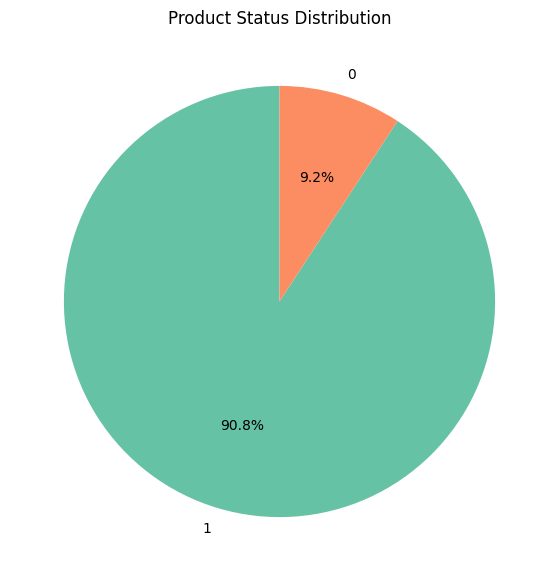

In [4]:
# Distribution of product status (e.g., active, discontinued, etc.)
status_count = final_products.status.value_counts()
plt.figure(figsize=(7, 7))
status_count.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', len(status_count)))
plt.title('Product Status Distribution')
plt.ylabel('')
plt.show()

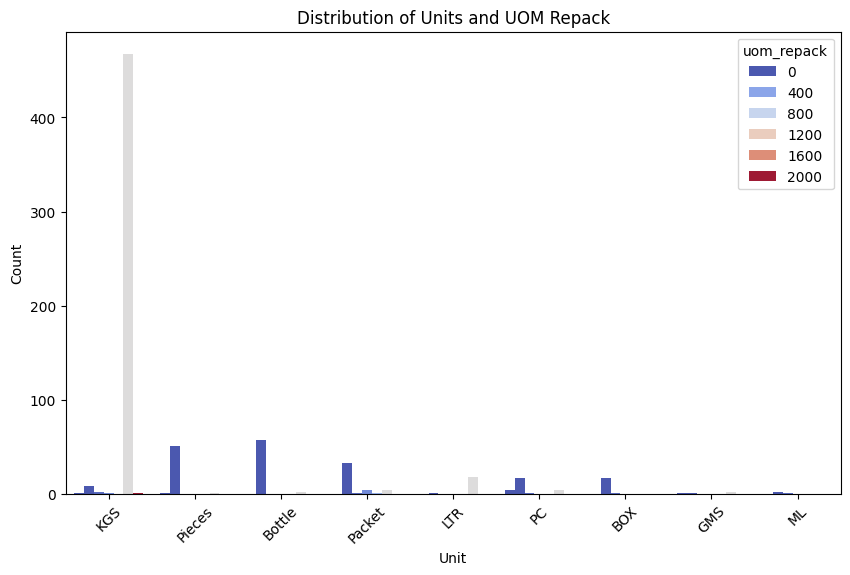

In [5]:
# Count plot to see how 'unit' and 'uom_repack' are distributed
plt.figure(figsize=(10, 6))
sns.countplot(x='unit', hue='uom_repack', data=final_products, palette='coolwarm')
plt.title('Distribution of Units and UOM Repack')
plt.xlabel('Unit')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Order Cleaning
Clean and consolidate order data to ensure accuracy and consistency for further analysis.


In [6]:
# Combine the 3 order tables (archive orders, current orders, and bundle orders) into a single DataFrame
# 1. archive_orders: Contains older orders
# 2. orders: Contains current year orders
# 3. bundle_orders: Contains orders with bundle products (products grouped together)
final_orders = pd.concat([archive_orders, orders, bundle_orders], ignore_index=True)

In [7]:
# Dropping the 'product_type' column since it only has one value.
# This column was originally used to identify bundle products, but since we've 
# already converted all bundle products to single products, it's no longer necessary.
final_orders = final_orders.drop(columns=['product_type'])

# Ensure SKU column values are consistent by converting all to strings
final_orders['sku'] = final_orders.sku.astype(str)

# Extract the first word from customer_type to classify orders as B2B or B2C, ignoring further details
final_orders['order_category'] = final_orders.customer_type.str.split().str[0]

# Filling empty columns with default 
final_orders['discount']= final_orders.discount.fillna(0)
final_orders['coupon_code'] = final_orders.coupon_code.fillna('-')
final_orders['order_source'] = np.where(final_orders.order_source.isna() & final_orders.order_category.str.startswith('B2B'), 'offline', 'online')

# Remove rows where 'qty' column has NaN values
final_orders = final_orders.dropna(subset=['qty'])

# Drop rows where delivery_date equals "0001-11-30" which seems to be some dummy date
final_orders = final_orders[final_orders.delivery_date != '0001-11-30']
# Replace '0022' with '2022' in the delivery_date column
final_orders['delivery_date'] = final_orders.delivery_date.str.replace('0022', '2022', regex=False)

# Convert Date to Datetime format
final_orders['delivery_date'] = pd.to_datetime(final_orders.delivery_date)

# Remove some products (dummy product, delivery charge, carry bag, membership purchase) from inventory prediction.
excluded_skus = ['90000_0012', '90000_0003', '90000_0006', '80006', '80005', '99999_99999']
final_orders = final_orders[~final_orders['sku'].isin(excluded_skus)]

### Order Visualization
Visualize order trends and patterns to gain insights into customer behavior, product demand, and seasonal variations.

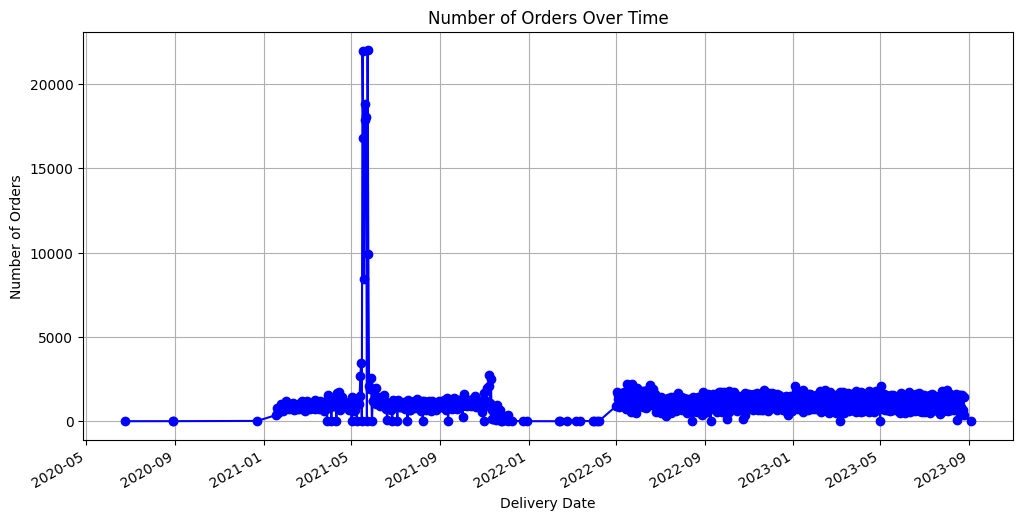

In [8]:
#Plotting the daily trend of orders over time:
orders_trend = final_orders.groupby('delivery_date')['order_id'].count()
plt.figure(figsize=(12, 6))
orders_trend.plot(kind='line', marker='o', color='blue')
plt.title('Number of Orders Over Time')
plt.xlabel('Delivery Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

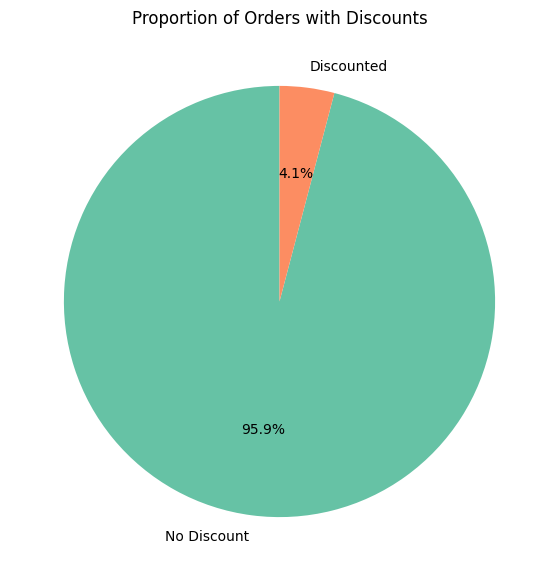

In [9]:
# Check how many orders had discounts
discount_data = final_orders.discount.apply(lambda x: 'Discounted' if x > 0 else 'No Discount').value_counts()
plt.figure(figsize=(7, 7))
discount_data.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', len(discount_data)))
plt.title('Proportion of Orders with Discounts')
plt.ylabel('')
plt.show()

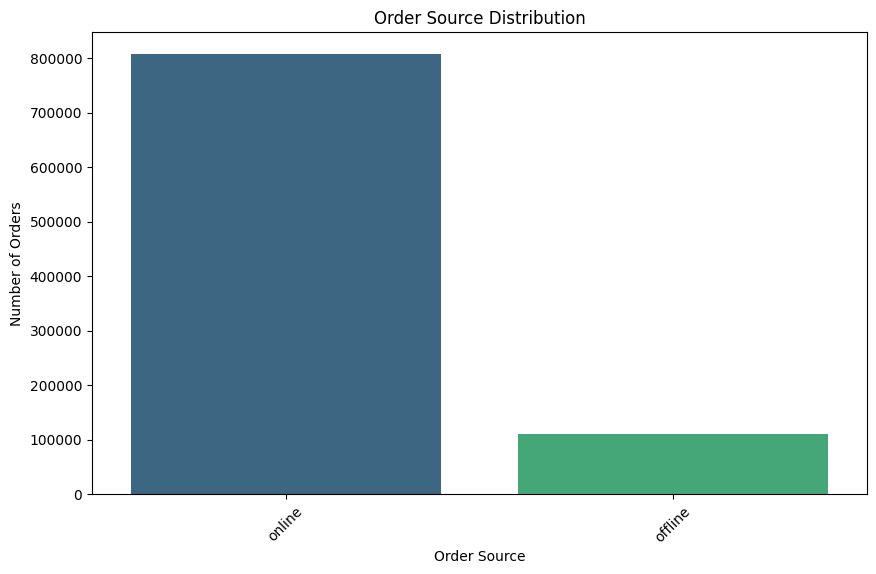

In [10]:
# Count the number of orders by source
order_source_count = final_orders.order_source.value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=order_source_count.index, y=order_source_count.values, hue=order_source_count.index, palette='viridis')
plt.title('Order Source Distribution')
plt.xlabel('Order Source')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

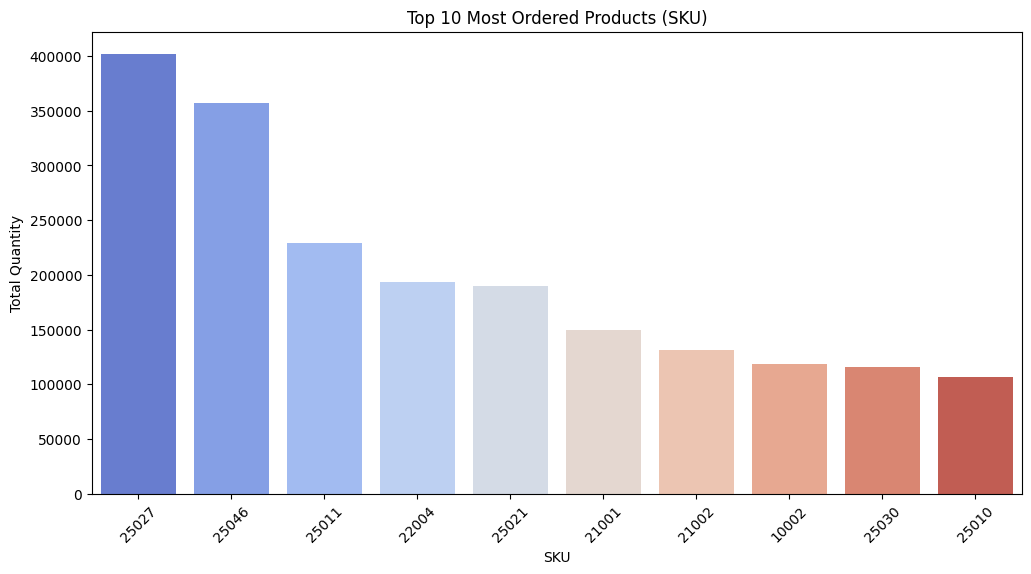

In [11]:
# Group data by SKU and sum up quantities
sku_popularity = final_orders.groupby('sku').qty.sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=sku_popularity.index, y=sku_popularity.values, hue=sku_popularity.index, palette='coolwarm')
plt.title('Top 10 Most Ordered Products (SKU)')
plt.xlabel('SKU')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.show()

### Feature Engineering
Create and transform features to enhance model performance by capturing important patterns and relationships in the data.

In [12]:
# Track repeat purchases and calculate the time gap (in days) since the last purchase for each customer and product.
final_orders = final_orders.sort_values(by=['customer', 'sku', 'delivery_date'])
final_orders['prev_purchase_date'] = final_orders.groupby(['customer', 'sku'])['delivery_date'].shift(1)
final_orders['repeat_purchase'] = final_orders.prev_purchase_date.notna().astype(int)
final_orders['days_since_last_purchase'] = (final_orders.delivery_date - final_orders.prev_purchase_date).dt.days
final_orders['days_since_last_purchase'] = final_orders.days_since_last_purchase.fillna(-1)

# Calculate the delivery gap as the number of days between the order date and the delivery date.
final_orders['order_date'] = pd.to_datetime(final_orders.order_date)
final_orders['delivery_gap'] = (final_orders.delivery_date - final_orders.order_date).dt.days
final_orders['delivery_gap'] = final_orders.delivery_gap.fillna(-1)

# Check if discount and coupon code are applied to calculate percentage, which can help in analyzing marketing activities.
final_orders['coupon_code_status'] = final_orders.coupon_code.apply(lambda x: 1 if x not in ['-', ''] else 0)
final_orders['discount_status'] = final_orders.discount.apply(lambda x: 1 if x > 0 else 0)

# Flag unusual high number of orders for marketing activity
final_orders['order_count'] = final_orders.groupby(['delivery_date','sku'])['order_id'].transform('count')
final_orders['ema_order_count'] = final_orders.groupby('sku')['order_count'].transform(lambda x: x.ewm(span=7, adjust=False).mean())
mean_ema_order_count = final_orders['ema_order_count'].mean()
std_ema_order_count = final_orders['ema_order_count'].std()
final_orders['marketing_activity'] = (final_orders['ema_order_count'] > mean_ema_order_count + 2 * std_ema_order_count).astype(int)

# Identify first order for each product and Mark as "new product" if within the first week (7 days) of its first order
final_orders['first_order'] = final_orders.groupby('sku')['delivery_date'].transform('min')
final_orders['days_since_first_order'] = (final_orders['delivery_date'] - final_orders['first_order']).dt.days
final_orders['is_new_product'] = (final_orders['days_since_first_order'] <= 7).astype(int)

# Calculate the adjusted quantity from quantity and the unit qty.
final_orders['adjusted_qty'] = final_orders.qty * final_orders.uom_repack

# Group the data by delivery date and SKU to get the total ordered qty count for a particular product each day.
inventory_data = final_orders.groupby(['delivery_date', 'sku'], as_index=False).agg({
    'adjusted_qty': 'sum',
    'discount_status': 'mean',
    'coupon_code_status': 'mean',
    'days_since_last_purchase': 'min',
    'delivery_gap': 'mean',
    'repeat_purchase': 'mean',
    'order_count': 'first',
    'marketing_activity': 'first',
    'is_new_product': 'first',
})
# Calculate B2C and B2B order counts
customer_type_counts = final_orders.pivot_table(index=['delivery_date', 'sku'], columns='order_category', aggfunc='size', fill_value=0).reset_index()
customer_type_counts = customer_type_counts.rename(columns={'B2C': 'b2c_count', 'B2B': 'b2b_count'})
inventory_data = inventory_data.merge(customer_type_counts[['delivery_date', 'sku', 'b2c_count', 'b2b_count']], on=['delivery_date', 'sku'], how='left')

# Calculate proportion and dominant customer type
inventory_data['b2c_ratio'] = inventory_data['b2c_count'] / inventory_data['order_count']
inventory_data['dominant_customer_type'] = inventory_data.apply(
    lambda row: 'B2C' if row['b2c_count'] > row['b2b_count'] else 'B2B',
    axis=1
)
# Merge the product data with the inventory data based on SKU.
final_inventory = pd.merge(inventory_data, final_products, on='sku', how='inner')

In [13]:
# Calculate the actual product quantity by dividing the adjusted quantity by the repack unit (uom_repack).
# This gives the total quantity of the main product purchased, accounting for different pack sizes.
final_inventory['product_qty'] = final_inventory.adjusted_qty / final_inventory.uom_repack

# Creating marketing activity status for product based on coupon code and discount status applied or not
final_inventory['marketing_status'] = (final_inventory.coupon_code_status + final_inventory.discount_status) / 2

# Extract the day, month, year, and day of the week
final_inventory['day'] = final_inventory.delivery_date.dt.day
final_inventory['month'] = final_inventory.delivery_date.dt.month
final_inventory['year'] = final_inventory.delivery_date.dt.year
final_inventory['day_of_week'] = final_inventory.delivery_date.dt.day_name()
final_inventory['week_of_year'] = final_inventory.delivery_date.dt.isocalendar().week
final_inventory['is_weekend'] = final_inventory.delivery_date.dt.weekday >= 5

# Create a 'season' column to identify seasonal trends in product demand.
conditions = [
    final_inventory['month'].isin([12, 1, 2]),  # Winter: December to February
    final_inventory['month'].isin([3, 4, 5]),  # Summer: March to May
    final_inventory['month'].isin([6, 7, 8, 9]),  # Monsoon: June to September
    final_inventory['month'].isin([10, 11])  # Post-Monsoon: October to November
]
labels = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
final_inventory['season'] = np.select(conditions, labels, default='Unknown')


# # Aggregate sales across different time periods and sorting products by sales volume.
final_inventory['product_sales_rank'] = final_inventory.groupby('sku').product_qty.rank(ascending=False)

# # Compute rolling averages (7-day, 30-day) to smooth out short-term fluctuations and capture long-term trends.
inventory_temp = final_inventory.sort_values(by=['sku', 'delivery_date'])
final_inventory['rolling_avg_7'] = inventory_temp.groupby('sku').product_qty.transform(lambda x: x.rolling(window=7, min_periods=1).mean())
final_inventory['rolling_avg_30'] = inventory_temp.groupby('sku').product_qty.transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# Create Lag features for product quantity: previous day's product qty and 7 days ago for each SKU
final_inventory['lag_1_product_qty'] = final_inventory.groupby('sku')['product_qty'].shift(1)
final_inventory['lag_7_product_qty'] = final_inventory.groupby('sku')['product_qty'].shift(7)
final_inventory['lag_1_product_qty'] = final_inventory.groupby('sku')['lag_1_product_qty'].transform(lambda x: x.fillna(x.mean()))
final_inventory['lag_7_product_qty'] = final_inventory.groupby('sku')['lag_7_product_qty'].transform(lambda x: x.fillna(x.mean()))

In [14]:
# Add holiday information to the inventory data
# We used the Abstract API to fetch holiday data, which was updated in a separate notebook due to API rate limits.
# The holiday data includes year, month, day, and holiday type.
# This also determines whether a specific date is a holiday and categorizes it accordingly.

# Standardize holiday types by merging similar categories into a single type
holiday_list.loc[holiday_list.type == 'National,Hindu','type'] = 'National'
holiday_list.loc[holiday_list.type == 'Season','type'] = 'Seasonal'
holiday_list['type'] = holiday_list.type.str.split().str[0]

# Count the number of holidays on each date to capture multiple holidays occurring on the same day
holiday_list['holiday_count'] = holiday_list.groupby('date')['type'].transform('count')

# Assign priority to holiday types, retaining only the highest-priority holiday for each date
holiday_priority = {
    'National': 1,
    'Optional': 2,
    'Observance': 3,
    'Seasonal': 4
}
holiday_list['priority'] = holiday_list['type'].map(holiday_priority)
holiday_final = holiday_list.sort_values(['date', 'priority']).drop_duplicates('date')


holiday_final = holiday_final.rename(columns={
    'date_year': 'year',
    'date_month': 'month',
    'date_day': 'day',
    'type': 'holiday_type'
})
holiday_final['year'] = holiday_final.year.astype(int)
holiday_final['month'] = holiday_final.month.astype(int)
holiday_final['day'] = holiday_final.day.astype(int)

final_inventory = pd.merge(
    final_inventory,
    holiday_final[['year', 'month', 'day', 'holiday_type', 'holiday_count']],
    on=['year', 'month', 'day'],
    how='left'
)
# Create a flag to indicate whether the date is a holiday, fill missing holiday types with 'No Holiday,' and set missing holiday counts to 0
final_inventory['is_holiday'] = final_inventory.holiday_type.notna().astype(int)
final_inventory['holiday_type'] = final_inventory.holiday_type.fillna('No Holiday')
final_inventory['holiday_count'] = final_inventory['holiday_count'].fillna(0).astype(int)

In [15]:
# Calculate whether a holiday is within 7 days of each delivery date
holiday_list['date'] = pd.to_datetime(holiday_list['date'])
final_inventory['delivery_date'] = pd.to_datetime(final_inventory['delivery_date'])
unique_delivery_dates = pd.DataFrame(final_inventory['delivery_date'].unique(), columns=['delivery_date'])

unique_delivery_dates['days_to_holiday'] = unique_delivery_dates['delivery_date'].apply(
    lambda x: (holiday_list['date'] - x).dt.days.clip(lower=0).min()
)
unique_delivery_dates['days_to_holiday'] = unique_delivery_dates['days_to_holiday'].apply(lambda x: x if x <= 7 else -1)
unique_delivery_dates['is_near_holiday'] = unique_delivery_dates['days_to_holiday'].apply(lambda x: 0 if x == -1 else 1)

final_inventory = final_inventory.merge(unique_delivery_dates, on='delivery_date', how='left')

# Sort by date
final_inventory = final_inventory.sort_values(by='delivery_date')

In [16]:
# Create a dictionary for quick look-up of category hierarchy
category_hierarchy = dict(zip(categories['id'], categories['name']))

# Function to find the top-most (main) category for each SKU
def get_main_category(category_id):
    while category_id is not None:
        parent_category_id = categories.loc[categories.id == category_id, 'parent'].values[0]
        if parent_category_id == 0:
            return category_hierarchy[category_id]
        category_id = parent_category_id
    return category_hierarchy[category_id]

# Assuming 'final_inventory' has a 'category_id' column for each SKU
categories['main_category'] = categories.id.apply(lambda x: get_main_category(x))
categories['category'] = categories.name

# Remove duplicate categories
categories = categories.drop_duplicates(subset=['name'], keep='last')

final_inventory = pd.merge(final_inventory,categories[['main_category', 'category']], on='category', how='left')

# Grains & Cereals catgeory only had 1 product in it so we shifted to a similar product category
final_inventory.loc[final_inventory.main_category == 'Grains & Cereals', 'main_category'] = 'KITCHEN ESSENTIALS'

# Add 'main_category' column to final_products from categories
final_products = pd.merge(final_products, categories[['category', 'main_category']], on='category', how='left')
final_products.loc[final_products.main_category == 'Grains & Cereals', 'main_category'] = 'KITCHEN ESSENTIALS'

In [17]:
# Combining Text based columns for preprocessing
final_inventory['combined_text'] = final_inventory.name + ' ' + final_inventory.category

# Reorder the 'product_qty' column to be the last column
cols = [col for col in final_inventory.columns if col != 'product_qty']  # List all columns except 'product_qty'
final_inventory = final_inventory[cols + ['product_qty']]  # Add 'product_qty' as the last column

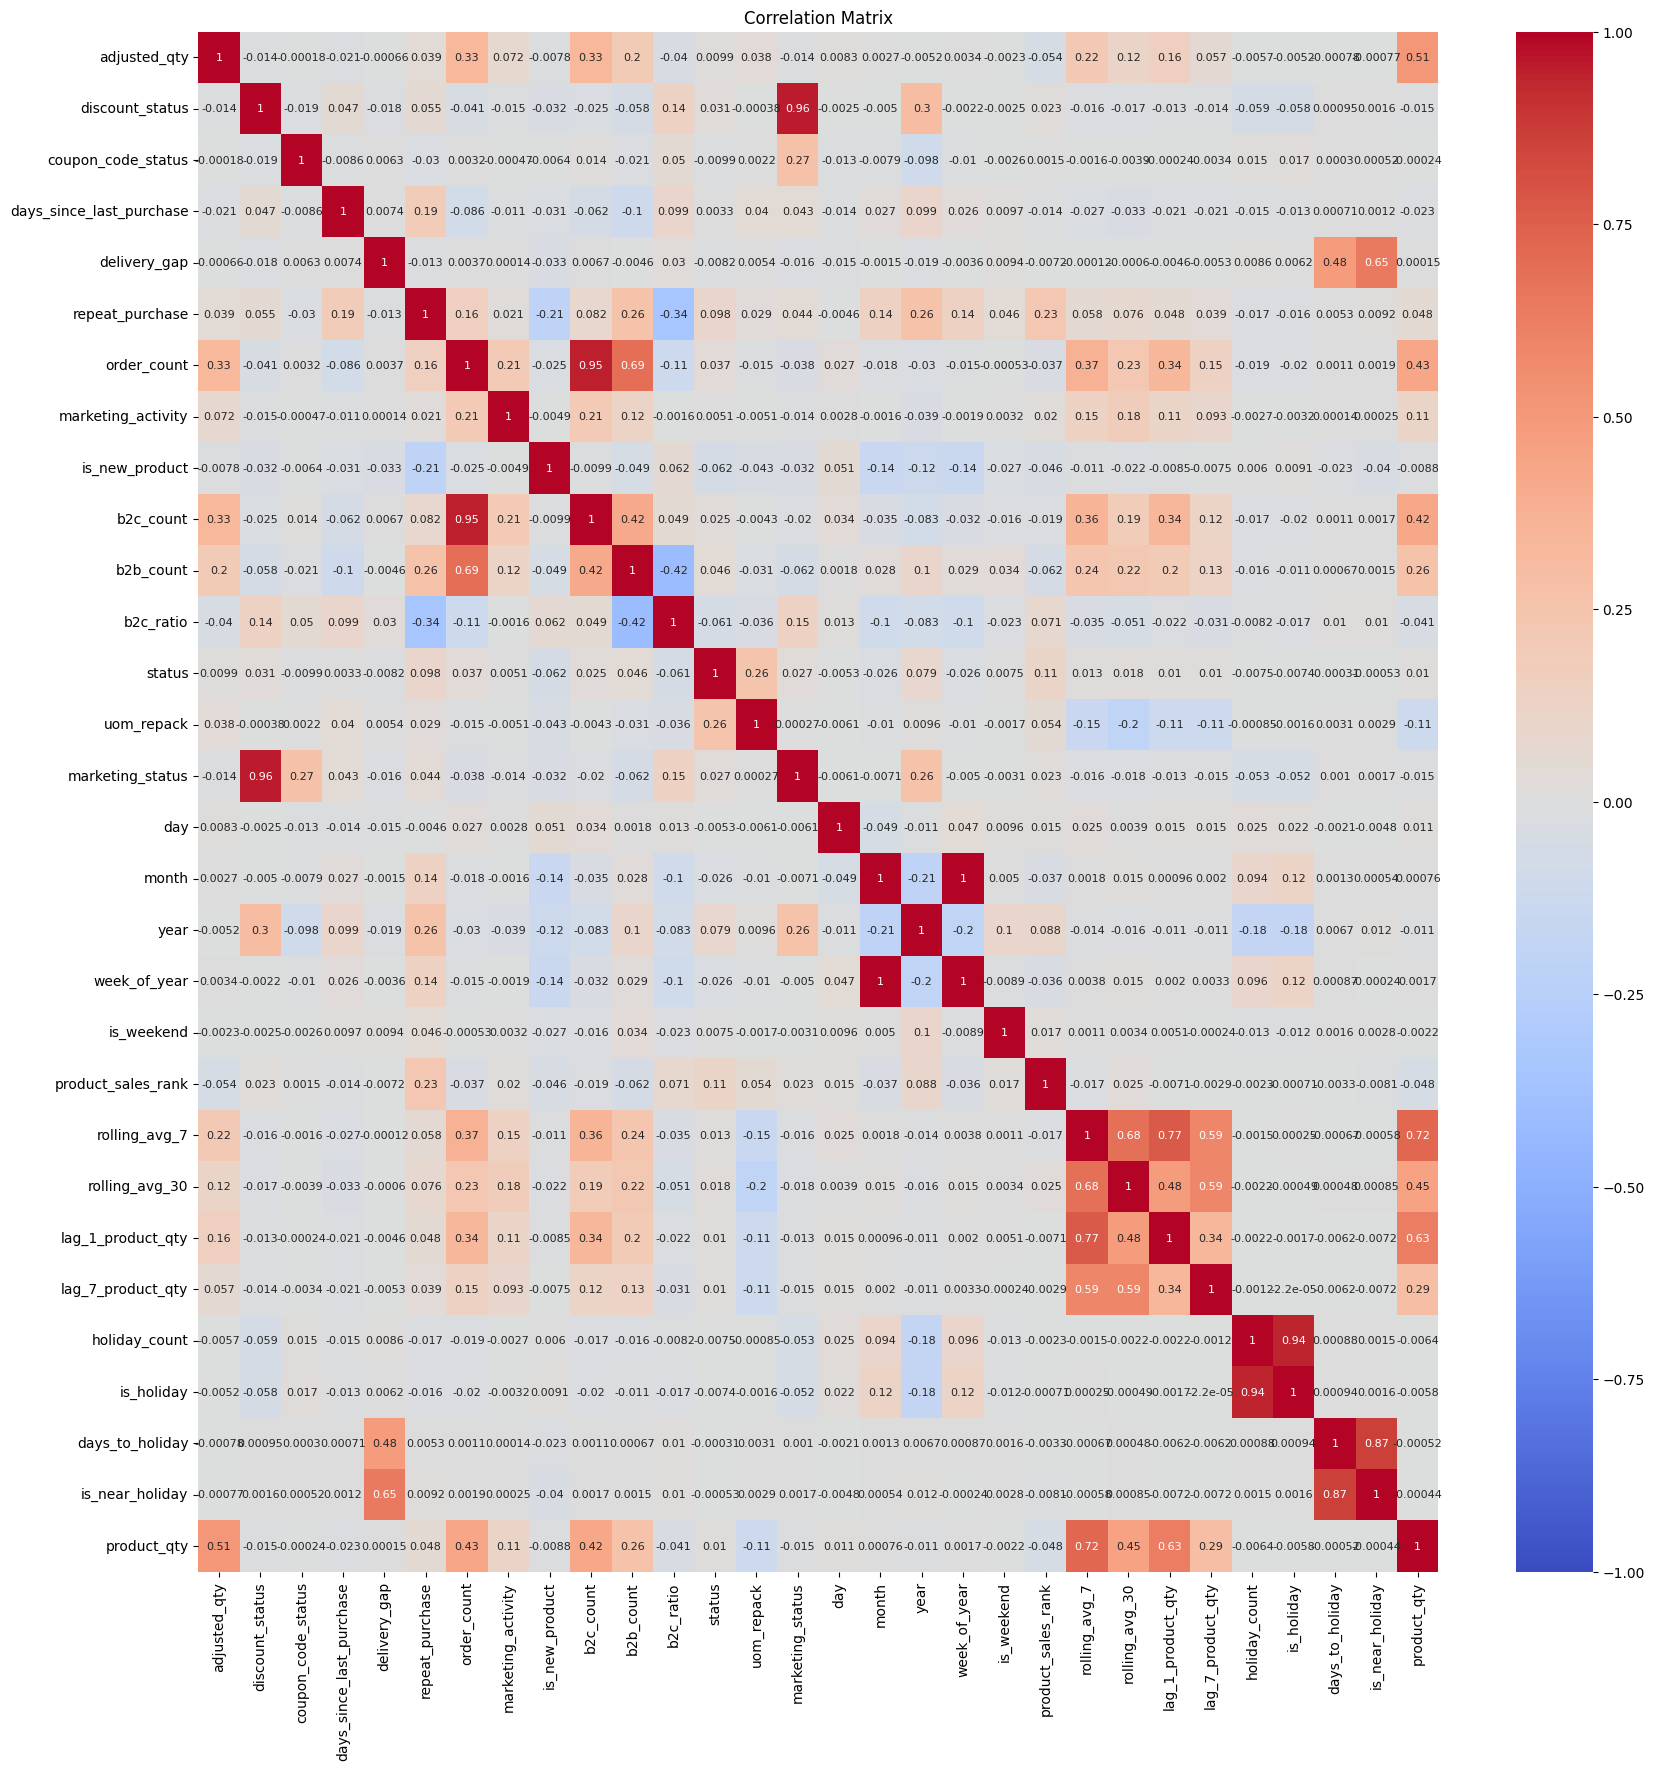

In [18]:
# Visualizing the correlation matrix to understand relationships between numerical features.
plt.figure(figsize=(20, 20))
corr = final_inventory.corr(numeric_only="True")
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,annot_kws={"size":8})
plt.title('Correlation Matrix')
plt.show()

In [19]:
final_inventory = final_inventory.sort_values(by='delivery_date')

### Seasonal Decomposition with STL
Use the STL (Seasonal and Trend decomposition using Loess) method to separate the seasonal, trend, and residual components of time series data.

In [20]:
from statsmodels.tsa.seasonal import STL
# Group by SKU (or other aggregation) to decompose time series for each product
decomposed_data = []
for sku in final_inventory['sku'].unique():
    sku_data = final_inventory[final_inventory['sku'] == sku]
    sku_data = sku_data.set_index('delivery_date')
    
    # Perform STL decomposition (with seasonal period based on your data, e.g., 7 for weekly seasonality)
    stl = STL(sku_data['product_qty'], period=7, robust=True)  # Adjust 'period' for weekly, monthly seasonality
    result = stl.fit()

    # Add decomposed components to the dataframe
    sku_decomposed = sku_data[['sku']].copy()
    sku_decomposed['trend'] = result.trend
    sku_decomposed['seasonal'] = result.seasonal
    sku_decomposed['residual'] = result.resid
    sku_decomposed.reset_index(inplace=True) 
    decomposed_data.append(sku_decomposed)
    
decomposed_df = pd.concat(decomposed_data)
# Now merge the decomposed components back into the original final_inventory DataFrame
final_inventory1 = final_inventory.merge(decomposed_df,
                                        on=['sku', 'delivery_date'], how='left')

### Category-wise Forecasting and Model Evaluation

Since the demand for different product categories varies, a category-wise model will be created for more accurate predictions. We will use **GridSearchCV** to find the optimal parameters for the **XGBRegressor** model. ARIMAX or SARIMAX models will not be used, as the focus is on forecasting product-wise sales quantities.

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'enable_categorical': [True],
    'objective': ['reg:squarederror'],
    'enable_categorical': [True]
}
results = []

category_list = final_inventory['main_category'].unique()

# Define the TF-IDF vectorizer for the 'name' column
tfidf = TfidfVectorizer(max_features=100, stop_words='english',min_df=2)  # You can adjust max_features to control the size of the vectorized features

# Iterate through each category
for category in category_list:
    category_data = final_inventory[final_inventory['main_category'] == category]

    # Tokenize the 'name' column
    X_name = tfidf.fit_transform(category_data['name'])
    X_name_df = pd.DataFrame(X_name.toarray(), columns=tfidf.get_feature_names_out())
    category_data_cleaned = category_data.drop(columns=['product_qty', 'delivery_date', 'name', 'adjusted_qty', 'combined_text', 'status']).reset_index(drop=True)

    # Adding type as category for categorical columns
    categorical_columns = ['sku', 'category', 'unit', 'uom_repack' ,'season', 'day_of_week', 'holiday_type' , 'main_category', 'dominant_customer_type']
    category_data_cleaned[categorical_columns] = category_data_cleaned[categorical_columns].astype('category')
    category_data_cleaned = category_data_cleaned.rename(columns={
        'year': 'date_year',
        'month': 'date_month',
        'day': 'date_day'
    })
    
    # Split the data into features (X) and target (y)
    X = pd.concat([category_data_cleaned, X_name_df], axis=1)
    y = category_data['product_qty']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    
    xgb_model = XGBRegressor()
    
    # Perform GridSearchCV to find the best hyperparameters for the category
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics for the current category
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        'category': category,
        'best_params': grid_search.best_params_,
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    })

In [22]:
results_df = pd.DataFrame(results)
results_df

,category,best_params,r2,mae,rmse
0,FRESH PRODUCE,"{'colsample_bytree': 1.0, 'enable_categorical'...",0.989018,2.778966,7.572541
1,KITCHEN ESSENTIALS,"{'colsample_bytree': 0.8, 'enable_categorical'...",0.448825,10.903618,153.227159
2,SPICES & SEASONINGS,"{'colsample_bytree': 1.0, 'enable_categorical'...",0.371304,0.785227,10.953347
3,GOURMET PANTRY,"{'colsample_bytree': 0.8, 'enable_categorical'...",0.473181,1.124086,3.368533
4,SNACKS & MUNCHIES,"{'colsample_bytree': 0.8, 'enable_categorical'...",0.787553,5.523758,15.832235
5,GIFTING,"{'colsample_bytree': 0.8, 'enable_categorical'...",-84.771545,14.627537,19.949435
6,OTHER PRODUCTS,"{'colsample_bytree': 0.8, 'enable_categorical'...",0.134934,0.676439,1.128525


### Analysis of R² Scores for Inventory Forecasting

#### Observations

- **Seasonal Demand:** Certain products show lower R² scores due to seasonal buying patterns. For example: Products purchased mainly during the Diwali season or other holidays.

- **Recent Category Creation:** Newly created product categories have insufficient historical data, impacting model accuracy.

- **Marketing and Product Expansion:** Recent increases in product purchases caused by:
  - Marketing activities.
  - The addition of new products in specific categories.

#### Key Achievement

The primary goal of predicting stock for **fresh produce** has been achieved with impressive results:
- **R² Score:** Achieved a near-perfect score of **0.98**, demonstrating the model's effectiveness in forecasting fresh produce inventory.

#### Next Steps

- Train the model on the **entire dataset**, categorized by product type, using the best hyperparameters identified through **GridSearchCV**.
ugh **GridSearchCV**.


In [33]:
final_result = []
for result in results:
    category = result['category']
    best_params = result['best_params']
    category_data = final_inventory[final_inventory['main_category'] == category]

    # Tokenize the 'name' column
    tfidf = TfidfVectorizer(max_features=100, stop_words='english',min_df=2)
    X_name = tfidf.fit_transform(category_data['name'])
    X_name_df = pd.DataFrame(X_name.toarray(), columns=tfidf.get_feature_names_out())
    category_data_cleaned = category_data.drop(columns=['product_qty', 'delivery_date', 'name', 'adjusted_qty', 'combined_text', 'status']).reset_index(drop=True)

    # Adding type as category for categorical columns
    categorical_columns = ['sku', 'category', 'unit', 'uom_repack' ,'season', 'day_of_week', 'holiday_type' , 'main_category', 'dominant_customer_type']
    category_data_cleaned[categorical_columns] = category_data_cleaned[categorical_columns].astype('category')
    category_data_cleaned = category_data_cleaned.rename(columns={
        'year': 'date_year',
        'month': 'date_month',
        'day': 'date_day'
    })
    
    # Split the data into features (X) and target (y)
    X = pd.concat([category_data_cleaned, X_name_df], axis=1)
    y = category_data['product_qty']
    
    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X, y)

    X_order_count = X.drop(columns=['order_count','b2b_count', 'b2c_count', 'dominant_customer_type'])
    y_order_count = category_data['order_count']
    xgb_model_order_count = XGBRegressor(**best_params)
    xgb_model_order_count.fit(X_order_count, y_order_count)
    
    final_result.append({
        'category': category,
        'model': xgb_model,
        'model_order_count': xgb_model_order_count,
        'name_columns': tfidf.get_feature_names_out(),
        'tfidf': tfidf
    })

### Forecasting Inventory for Next 7 Days
Preparing the forecast data by creating relevant columns from past data, upcoming marketing activities, and forecasting the product quantity needed in the inventory.

In [99]:
forecast_dates = pd.date_range(start=final_inventory['delivery_date'].max() + pd.Timedelta(days=1), periods=7, freq='D')
future_data = pd.DataFrame({
        'delivery_date': forecast_dates,
        'year': forecast_dates.year,
        'month': forecast_dates.month,
        'day': forecast_dates.day,
        'day_of_week': forecast_dates.dayofweek,
        'is_weekend': (forecast_dates.weekday >= 5).astype('int'),
        'week_of_year': forecast_dates.isocalendar().week
    })

# Season
conditions = [
    future_data['month'].isin([12, 1, 2]),  # Winter: December to February
    future_data['month'].isin([3, 4, 5]),  # Summer: March to May
    future_data['month'].isin([6, 7, 8, 9]),  # Monsoon: June to September
    future_data['month'].isin([10, 11])  # Post-Monsoon: October to November
]
labels = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
future_data['season'] = np.select(conditions, labels, default='Unknown')

# Holiday Details
# For now using manual addition of holiday data but we can use Abstract API instead. But due to low credits for free usage will be adding manually only
holiday_counts = final_inventory.holiday_type.value_counts(normalize=True)
holiday_types = holiday_counts.index
holiday_probabilities = holiday_counts.values
future_data['holiday_type'] = np.random.choice(holiday_types, size=len(future_data), p=holiday_probabilities)
future_data['is_holiday'] = future_data['holiday_type'].apply(lambda x: 1 if x != 'No Holiday' else 0)
future_data['holiday_count'] = future_data.apply(lambda row: np.random.randint(1, 3) if row['holiday_type'] != 'No Holiday' else 0, axis=1)
future_data['days_to_holiday'] = future_data['delivery_date'].apply(lambda x: (holiday_list['date'] - x).dt.days.clip(lower=0).min())
future_data['days_to_holiday'] = future_data['days_to_holiday'].apply(lambda x: x if x <= 7 else -1)
future_data['is_near_holiday'] = future_data['days_to_holiday'].apply(lambda x: 0 if x == -1 else 1)

future_data.reset_index(drop=True, inplace= True)

# Repeat the forecasted data for each product (sku) in final_products and merge with the product details
future_data_repeated = pd.DataFrame(np.tile(future_data.values, (len(final_products), 1)), columns=future_data.columns)
future_data_repeated['sku'] = np.tile(final_products['sku'].values, len(future_data))
final_future_data = pd.merge(future_data_repeated, final_products, on='sku', how='left')
final_future_data = final_future_data.sort_values(by=['delivery_date','sku'])

# Remove some products (dummy product, delivery charge, carry bag, membership purchase) from inventory prediction.
excluded_skus = ['90000_0012', '90000_0003', '90000_0006', '80006', '80005', '99999_99999']
final_future_data = final_future_data[~final_future_data['sku'].isin(excluded_skus)]

# Remove products from final_future_data where status is 0
final_future_data = final_future_data[final_future_data['status'] != 0]

# Generate random values between 0 and 1, and assign 1 if it's less than the probability
probability_of_new_product = 0.01
final_future_data['is_new_product'] = np.random.rand(len(final_future_data)) < probability_of_new_product

# Calcuate rolling averages and lag values from historical data
historical_data = final_inventory[['sku', 'rolling_avg_7', 'rolling_avg_30', 'lag_1_product_qty', 'lag_7_product_qty']]
latest_values = historical_data.groupby('sku').last().reset_index()
final_future_data = pd.merge(final_future_data, latest_values, on='sku', how='left')
final_future_data['rolling_avg_7'] = final_future_data['rolling_avg_7'].fillna(final_future_data['rolling_avg_7'].mean())
final_future_data['rolling_avg_30'] = final_future_data['rolling_avg_30'].fillna(final_future_data['rolling_avg_30'].mean())
final_future_data['lag_1_product_qty'] = final_future_data['lag_1_product_qty'].fillna(final_future_data['lag_1_product_qty'].mean())
final_future_data['lag_7_product_qty'] = final_future_data['lag_7_product_qty'].fillna(final_future_data['lag_7_product_qty'].mean())

# Simulate discount and coupon code application percentages for future data based on past one month
last_month_data = final_inventory[final_inventory['delivery_date'] >= final_inventory['delivery_date'].max() - pd.Timedelta(days=30)]
discount_mean = last_month_data['discount_status'].mean()
discount_std = last_month_data['discount_status'].std()
coupon_mean = last_month_data['coupon_code_status'].mean()
coupon_std = last_month_data['coupon_code_status'].std()
final_future_data['discount_status'] = np.random.normal(
    loc=discount_mean,
    scale=discount_std,
    size=len(final_future_data)
).clip(0, 1)
final_future_data['coupon_code_status'] = np.random.normal(
    loc=coupon_mean,
    scale=coupon_std,
    size=len(final_future_data)
).clip(0, 1)

# Calcuate Marketing status from coupon_code_status and discount_status
final_future_data['marketing_status'] = (final_future_data.coupon_code_status + final_future_data.discount_status) / 2

# Assign random marketing activity values based on the defined probabilities
marketing_activity_weights = [0.9, 0.1]  # 80% probability for 0, 20% for 1
final_future_data['marketing_activity'] = np.random.choice(
    [0, 1],
    size=len(final_future_data), 
    p=marketing_activity_weights
)

# Compute the Product Sales Rank based on the average of the last 1 month
last_month_sales_rank_mean = last_month_data.groupby('sku')['product_sales_rank'].mean()
final_future_data['product_sales_rank'] = final_future_data['sku'].map(last_month_sales_rank_mean)
final_future_data['product_sales_rank'] = final_future_data['product_sales_rank'].fillna(last_month_data['product_sales_rank'].mean())

# Compute the Repeat Purchase Percentage, Gap bewtween Delivery date and order Date and days since last purchase based on the average of the last 1 month
avg_repeat_purchase_last_month = last_month_data.groupby('sku')['repeat_purchase'].mean().to_dict()
final_future_data['repeat_purchase'] = final_future_data['sku'].map(avg_repeat_purchase_last_month).fillna(0)

avg_delivery_gap_last_month = last_month_data.groupby('sku')['delivery_gap'].mean().to_dict()
final_future_data['delivery_gap'] = final_future_data['sku'].map(avg_delivery_gap_last_month).fillna(0)

avg_days_since_last_purchase_last_month = last_month_data.groupby('sku')['days_since_last_purchase'].mean().to_dict()
final_future_data['days_since_last_purchase'] = final_future_data['sku'].map(avg_days_since_last_purchase_last_month).fillna(-1)

# Compute the Product Sales Rank based on the average of the last 1 month
avg_b2c_ratio_last_month = last_month_data.groupby('sku')['b2c_ratio'].mean().to_dict()
final_future_data['b2c_ratio'] = final_future_data['sku'].map(avg_b2c_ratio_last_month).fillna(0)

# Add empty columns
final_future_data[['order_count', 'b2c_count', 'b2b_count']] = 0.0
final_future_data['dominant_customer_type'] = "B2C"
final_future_data['product_qty'] = 0.0

In [100]:
for result in final_result:
    category = result['category']
    model = result['model']
    model_order_count = result['model_order_count']
    tfidf = result['tfidf']
    category_forecast_data = final_future_data[final_future_data['main_category'] == category].copy()
    # Preprocessing
    category_forecast_data = category_forecast_data.rename(columns={
        'year': 'date_year',
        'month': 'date_month',
        'day': 'date_day'
    })
    categorical_columns = ['sku', 'category', 'unit', 'uom_repack' ,'season', 'day_of_week', 'holiday_type' , 'main_category', 'dominant_customer_type']
    category_forecast_data[categorical_columns] = category_forecast_data[categorical_columns].astype('category')
    numerical_columns = ['date_day', 'date_month', 'date_year', 'day_of_week' ,'week_of_year', 'is_weekend', 'holiday_count' ,
                         'is_holiday', 'days_to_holiday', 'is_near_holiday']
    category_forecast_data[numerical_columns] = category_forecast_data[numerical_columns].astype('int')
    
    X_name = tfidf.transform(category_forecast_data['name'])
    X_name_df = pd.DataFrame(X_name.toarray(), columns=tfidf.get_feature_names_out(), index=category_forecast_data.index)
    for col in tfidf.get_feature_names_out():
        if col not in X_name_df:
            X_name_df[col] = 0
    
    X_category = pd.concat([category_forecast_data, X_name_df], axis=1)
    X_order_quantity = X_category[model_order_count.feature_names_in_]
    # Predict Order Qty
    predicted_order_count = model_order_count.predict(X_order_quantity)
    category_forecast_data['order_count'] = predicted_order_count

    # Calcuate other features based on order quantity
    category_forecast_data['b2c_count'] = category_forecast_data['order_count'] * category_forecast_data['b2c_ratio']
    category_forecast_data['b2b_count'] = category_forecast_data['order_count'] - category_forecast_data['b2c_count']
    category_forecast_data['dominant_customer_type'] = category_forecast_data.apply(
        lambda row: 'B2C' if row['b2c_count'] > row['b2b_count'] else 'B2B',
        axis=1
    )
    final_future_data.update(category_forecast_data[['sku', 'order_count', 'b2c_count', 'b2b_count', 'dominant_customer_type']])

    # Predict Product Qty
    category_forecast_data['dominant_customer_type'] = category_forecast_data['dominant_customer_type'].astype('category')
    X = pd.concat([category_forecast_data, X_name_df], axis=1)
    X_main = X[model.feature_names_in_]
    predicted_qty = model.predict(X_main)
    category_forecast_data['product_qty'] = predicted_qty
    final_future_data.update(category_forecast_data[['sku', 'product_qty']])
    

In [106]:
# Displaying `delivery_date`, `sku`, `product_qty`, and calculated `+10%` and `-10%` adjustments for minimum and maximum inventory needs.
selected_columns = ['delivery_date', 'sku', 'product_qty']
output_data = final_future_data[selected_columns].copy()
output_data['product_qty'] = output_data['product_qty'].apply(math.ceil)
output_data['product_qty_plus_10%'] = (output_data['product_qty'] * 1.10).apply(math.ceil)
output_data['product_qty_minus_10%'] = (output_data['product_qty'] * 0.90).apply(math.ceil)

In [107]:
output_data

,delivery_date,sku,product_qty,product_qty_plus_10%,product_qty_minus_10%
0,2023-09-04,10001,7,8,7
1,2023-09-04,10002,176,194,159
2,2023-09-04,10003,3,4,3
3,2023-09-04,10004,70,77,63
4,2023-09-04,10005,5,6,5
...,...,...,...,...,...
4433,2023-09-10,80053,4,5,4
4434,2023-09-10,81001,94,104,85
4435,2023-09-10,81002,4,5,4
4436,2023-09-10,81003,2,3,2
